In [0]:
!pip install -q keras
!pip install -q python-binance

In [0]:
import pandas as pd
import numpy as np
import gc
from binance.client import Client
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import LSTM, Activation, Dense, Dropout, GRU
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

Using TensorFlow backend.


In [0]:
def get_data(api_key, api_secret, initial_date, final_date, pair, time_frame):
    
    '''Returns a DataFrame that contains all the information about the 
       historical price of a pair of cryptocurrencies '''
    
    client = Client(api_key, api_secret)
    klines = client.get_historical_klines(pair , time_frame, initial_date, final_date)
    information = np.array(klines, dtype=float)
    df = pd.DataFrame(information, columns=['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time',
             'Quote asset volume', 'Number of trades', 'Taker buy base asset volume',
             'Taker buy quote asset volume', 'Can be ignored'])
    df['Open time'] = pd.to_datetime(df['Open time'], utc=True, unit='ms')
    df['Close time'] = pd.to_datetime(df['Close time'], utc=True, unit='ms')
    #df.isnull().values.any()
    return df

def joint_info(data_set, labels):
    '''Joint the Columns from the Data-Frame'''
    columns = []
    for label in labels:
        columns.append(data_set[label])
    df = pd.concat(columns, axis=1)
    return df

def normalize_data(data):
    ds = data.values
    min_max_scaler = preprocessing.MinMaxScaler()
    dss = min_max_scaler.fit_transform(ds)
    df = pd.DataFrame(dss, columns=[data.columns])
    return df

def split(data, xvar, yvar, intl):
    #inf = joint_info(data, xvar)
    inf = pd.DataFrame(data[xvar])
    stinf = normalize_data(inf)
    data_set = pd.concat([inf, stinf], axis=1)
    
    intervals = []
    dl, ln = stinf.shape
    for i in range(dl-intl):
        interval = stinf[i:i+intl].values
        intervals.append(interval)
    X = np.array(intervals)
    Xtrain, Xtest = train_test_split(X, train_size=0.8, test_size=0.2, shuffle=False)
    
    Y = stinf[yvar][intl:].values
    Ytrain, Ytest = train_test_split(Y, train_size=0.8, test_size=0.2, shuffle=False)
    
    return data_set, Xtrain, Xtest, Ytrain, Ytest

def price_predic(neurons, epochs, batch_size, Xtrain, Xtest, Ytrain, Ytest):
    np.random.seed(0)
    model = Sequential()
    model.add(LSTM(neurons, return_sequences=True, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
    model.add(LSTM(neurons))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(Xtrain, Ytrain,
                        epochs=epochs,
                        batch_size=batch_size,
                        shuffle=False,
                        validation_data=(Xtest, Ytest))
    
    return model, history

def error(history):
    plt.figure(figsize=(20,8))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model train vs validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.grid()
    plt.show()

def recover_price(data, model, results, yvar):
    #Ytest.reshape(-1,1)
    col = data[yvar]
    c = col.values
    c = c.reshape(-1,1)
    scaler = preprocessing.MinMaxScaler()
    scaled = scaler.fit_transform(c)
    #INVERSE SCALING
    scaled_data = scaler.inverse_transform(results)
    return scaled_data

def plot_prices(price_predicted, Ytest_predicted):
    plt.figure(figsize=(20,8))
    plt.grid(True)
    plt.plot(price_predicted, label='Predicted')
    plt.plot(Ytest_predicted, label='Real')
    plt.legend()
    plt.show()

def plot_histogram(price_predicted, Ytest_predicted):
    plt.figure(figsize=(20,8))
    plt.grid(True)
    plt.hist(price_predicted - Ytest_predicted, 70)
    plt.show()
    
def plot_figure(label1, label2):
    '''Graph labe1 as a function of label2'''
    plt.figure(figsize=(20,8))
    plt.grid(True)
    plt.plot(label1, label2)
    plt.xlabel(label1.name)
    plt.ylabel(label2.name)
    #plt.title('Close Prices 2017-12-01 and 2018-01-01')
    plt.show()

In [0]:
api_key = 'IbpsF5kqc5Jr34cPrYtugWoIuuVf05GokqOC0TcS35mwtpb5UpsaST1fePtRJL7F0'
api_secret = 'kvWWitpU5fFMtucgr0YYIV0Z33Y1EwfEBRc57ey0G5UzHMmKgdWer8G1pwkWmjuc9'
initial_date ='1 Dec, 2015'
final_date ='1 Jan, 2019'
pair = "BTCUSDT"
time_frame = Client.KLINE_INTERVAL_1HOUR

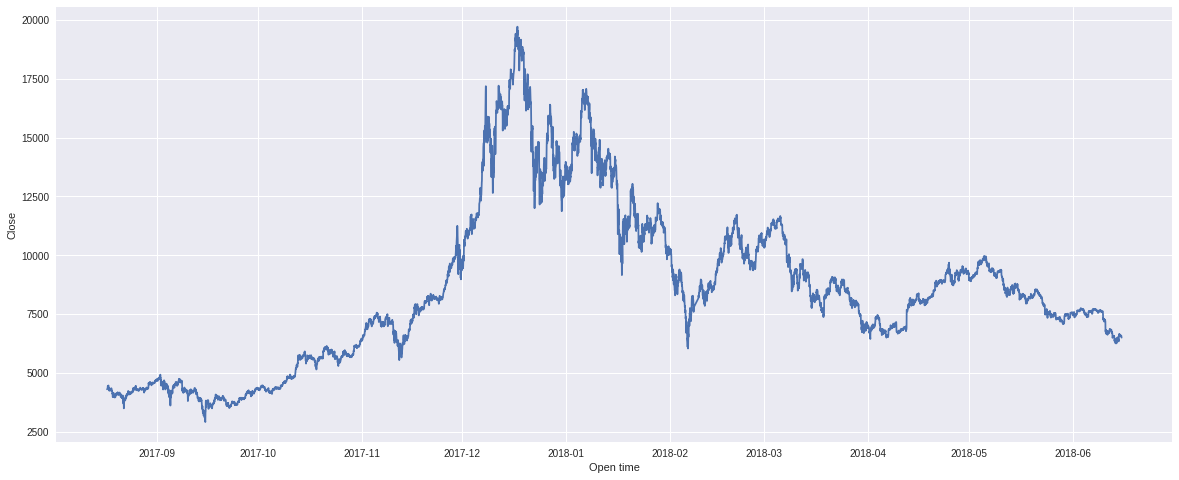

In [0]:
data = get_data(api_key, api_secret, initial_date, final_date, pair, time_frame)
plot_figure(data['Open time'], data['Close'])

# CLOSE PRICE PREDICTOR

In [0]:
#ERROR ELEVADO
#xvar = ('Close')
#yvar = ('Close')
#intl = 2

#neurons=168
#epochs=85
#batch_size=50

In [0]:
xvar = ('Close')
yvar = ('Close')
intl = 2

neurons=25
epochs=85
batch_size=45

data_Set, Close_Xtrain, Close_Xtest, Close_Ytrain, Close_Ytest = split(data, xvar, yvar, intl)

Close_XValidation = Close_Xtest[:int(Close_Xtest.shape[0]/2)]
Close_Xtest = Close_Xtest[int(Close_Xtest.shape[0]/2):]

#print(Close_XValidation.shape, Close_Xtest.shape)

Close_YValidation = Close_Ytest[:int(Close_Ytest.shape[0]/2)]
Close_Ytest = Close_Ytest[int(Close_Ytest.shape[0]/2):]

#print(Close_YValidation.shape, Close_Ytest.shape)

Close_pred, Close_history = price_predic(neurons, epochs, batch_size, Close_Xtrain, Close_XValidation, Close_Ytrain, Close_YValidation)

Train on 5772 samples, validate on 721 samples
Epoch 1/85
5772/5772 [==============================] - 2s 345us/step - loss: 0.0052 - val_loss: 0.0022
Epoch 2/85
5772/5772 [==============================] - 1s 138us/step - loss: 0.0120 - val_loss: 0.0011
Epoch 3/85
5772/5772 [==============================] - 1s 133us/step - loss: 0.0131 - val_loss: 9.4207e-04
Epoch 4/85
5772/5772 [==============================] - 1s 141us/step - loss: 0.0109 - val_loss: 7.4935e-04
Epoch 5/85
5772/5772 [==============================] - 1s 139us/step - loss: 0.0080 - val_loss: 5.5236e-04
Epoch 6/85
5772/5772 [==============================] - 1s 143us/step - loss: 0.0056 - val_loss: 4.0887e-04
Epoch 7/85
5772/5772 [==============================] - 1s 137us/step - loss: 0.0039 - val_loss: 3.2637e-04
Epoch 8/85
5772/5772 [==============================] - 1s 138us/step - loss: 0.0027 - val_loss: 2.8923e-04
Epoch 9/85
5772/5772 [==============================] - 1s 135us/step - loss: 0.0020 - val_loss: 

5772/5772 [==============================] - 1s 131us/step - loss: 0.0013 - val_loss: 3.1975e-04
Epoch 12/85
5772/5772 [==============================] - 1s 134us/step - loss: 0.0011 - val_loss: 3.5561e-04
Epoch 13/85
5772/5772 [==============================] - 1s 127us/step - loss: 9.3651e-04 - val_loss: 3.9865e-04
Epoch 14/85
5772/5772 [==============================] - 1s 133us/step - loss: 8.4496e-04 - val_loss: 4.4616e-04
Epoch 15/85
5772/5772 [==============================] - 1s 137us/step - loss: 7.7941e-04 - val_loss: 4.9522e-04
Epoch 16/85
5772/5772 [==============================] - 1s 138us/step - loss: 7.3032e-04 - val_loss: 5.4268e-04
Epoch 17/85
5772/5772 [==============================] - 1s 138us/step - loss: 6.9112e-04 - val_loss: 5.8526e-04
Epoch 18/85
5772/5772 [==============================] - 1s 139us/step - loss: 6.5702e-04 - val_loss: 6.1967e-04
Epoch 19/85
5772/5772 [==============================] - 1s 137us/step - loss: 6.2446e-04 - val_loss: 6.4287e-04
Epo

5772/5772 [==============================] - 1s 146us/step - loss: 5.5412e-04 - val_loss: 6.4587e-04
Epoch 22/85
5772/5772 [==============================] - 1s 142us/step - loss: 5.1342e-04 - val_loss: 6.2295e-04
Epoch 23/85
5772/5772 [==============================] - 1s 141us/step - loss: 4.6855e-04 - val_loss: 5.8409e-04
Epoch 24/85
5772/5772 [==============================] - 1s 145us/step - loss: 4.2032e-04 - val_loss: 5.3166e-04
Epoch 25/85
5772/5772 [==============================] - 1s 140us/step - loss: 3.7062e-04 - val_loss: 4.6957e-04
Epoch 26/85
5772/5772 [==============================] - 1s 137us/step - loss: 3.2221e-04 - val_loss: 4.0260e-04
Epoch 27/85
5772/5772 [==============================] - 1s 140us/step - loss: 2.7828e-04 - val_loss: 3.3552e-04
Epoch 28/85
5772/5772 [==============================] - 1s 141us/step - loss: 2.4164e-04 - val_loss: 2.7277e-04
Epoch 29/85
5772/5772 [==============================] - 1s 142us/step - loss: 2.1388e-04 - val_loss: 2.1859

5772/5772 [==============================] - 1s 148us/step - loss: 1.8394e-04 - val_loss: 1.4717e-04
Epoch 32/85
5772/5772 [==============================] - 1s 144us/step - loss: 1.7911e-04 - val_loss: 1.3001e-04
Epoch 33/85
5772/5772 [==============================] - 1s 136us/step - loss: 1.7937e-04 - val_loss: 1.2280e-04
Epoch 34/85
5772/5772 [==============================] - 1s 141us/step - loss: 1.8421e-04 - val_loss: 1.2406e-04
Epoch 35/85
5772/5772 [==============================] - 1s 144us/step - loss: 1.9385e-04 - val_loss: 1.3361e-04
Epoch 36/85
5772/5772 [==============================] - 1s 145us/step - loss: 2.0925e-04 - val_loss: 1.5295e-04
Epoch 37/85
5772/5772 [==============================] - 1s 141us/step - loss: 2.3229e-04 - val_loss: 1.8560e-04
Epoch 38/85
5772/5772 [==============================] - 1s 141us/step - loss: 2.6609e-04 - val_loss: 2.3808e-04
Epoch 39/85
5772/5772 [==============================] - 1s 137us/step - loss: 3.1539e-04 - val_loss: 3.2247

5772/5772 [==============================] - 1s 136us/step - loss: 4.8160e-04 - val_loss: 6.7714e-04
Epoch 42/85
5772/5772 [==============================] - 1s 140us/step - loss: 5.8755e-04 - val_loss: 9.4876e-04
Epoch 43/85
5772/5772 [==============================] - 1s 146us/step - loss: 6.6033e-04 - val_loss: 0.0011
Epoch 44/85
5772/5772 [==============================] - 1s 144us/step - loss: 6.5684e-04 - val_loss: 0.0011
Epoch 45/85
5772/5772 [==============================] - 1s 142us/step - loss: 5.8565e-04 - val_loss: 8.5449e-04
Epoch 46/85
5772/5772 [==============================] - 1s 143us/step - loss: 4.8828e-04 - val_loss: 6.0986e-04
Epoch 47/85
5772/5772 [==============================] - 1s 138us/step - loss: 3.9617e-04 - val_loss: 4.0418e-04
Epoch 48/85
5772/5772 [==============================] - 1s 140us/step - loss: 3.2290e-04 - val_loss: 2.5645e-04
Epoch 49/85
5772/5772 [==============================] - 1s 141us/step - loss: 2.7101e-04 - val_loss: 1.6283e-04
Epo

5772/5772 [==============================] - 1s 147us/step - loss: 2.1823e-04 - val_loss: 8.3083e-05
Epoch 52/85
5772/5772 [==============================] - 1s 144us/step - loss: 2.0895e-04 - val_loss: 7.2266e-05
Epoch 53/85
5772/5772 [==============================] - 1s 147us/step - loss: 2.0726e-04 - val_loss: 7.1718e-05
Epoch 54/85
5772/5772 [==============================] - 1s 146us/step - loss: 2.1201e-04 - val_loss: 7.9239e-05
Epoch 55/85
5772/5772 [==============================] - 1s 142us/step - loss: 2.2314e-04 - val_loss: 9.4777e-05
Epoch 56/85
5772/5772 [==============================] - 1s 144us/step - loss: 2.4148e-04 - val_loss: 1.1978e-04
Epoch 57/85
5772/5772 [==============================] - 1s 144us/step - loss: 2.6861e-04 - val_loss: 1.5735e-04
Epoch 58/85
5772/5772 [==============================] - 1s 149us/step - loss: 3.0644e-04 - val_loss: 2.1303e-04
Epoch 59/85
5772/5772 [==============================] - 1s 144us/step - loss: 3.5575e-04 - val_loss: 2.9445

5772/5772 [==============================] - 1s 144us/step - loss: 4.6233e-04 - val_loss: 5.1452e-04
Epoch 62/85
5772/5772 [==============================] - 1s 138us/step - loss: 4.8522e-04 - val_loss: 5.6946e-04
Epoch 63/85
5772/5772 [==============================] - 1s 140us/step - loss: 4.6851e-04 - val_loss: 5.3142e-04
Epoch 64/85
5772/5772 [==============================] - 1s 140us/step - loss: 4.2834e-04 - val_loss: 4.4237e-04
Epoch 65/85
5772/5772 [==============================] - 1s 136us/step - loss: 3.7076e-04 - val_loss: 3.2398e-04
Epoch 66/85
5772/5772 [==============================] - 1s 139us/step - loss: 3.1557e-04 - val_loss: 2.2201e-04
Epoch 67/85
5772/5772 [==============================] - 1s 138us/step - loss: 2.7198e-04 - val_loss: 1.5139e-04
Epoch 68/85
5772/5772 [==============================] - 1s 135us/step - loss: 2.4160e-04 - val_loss: 1.0904e-04
Epoch 69/85
5772/5772 [==============================] - 1s 136us/step - loss: 2.2269e-04 - val_loss: 8.6963

5772/5772 [==============================] - 1s 134us/step - loss: 2.1002e-04 - val_loss: 7.8821e-05
Epoch 72/85
5772/5772 [==============================] - 1s 137us/step - loss: 2.1336e-04 - val_loss: 8.6859e-05
Epoch 73/85
5772/5772 [==============================] - 1s 134us/step - loss: 2.2257e-04 - val_loss: 1.0220e-04
Epoch 74/85
5772/5772 [==============================] - 1s 137us/step - loss: 2.3807e-04 - val_loss: 1.2583e-04
Epoch 75/85
5772/5772 [==============================] - 1s 140us/step - loss: 2.6063e-04 - val_loss: 1.5983e-04
Epoch 76/85
5772/5772 [==============================] - 1s 137us/step - loss: 2.9084e-04 - val_loss: 2.0731e-04
Epoch 77/85
5772/5772 [==============================] - 1s 131us/step - loss: 3.2763e-04 - val_loss: 2.7037e-04
Epoch 78/85
5772/5772 [==============================] - 1s 138us/step - loss: 3.6585e-04 - val_loss: 3.4337e-04
Epoch 79/85
5772/5772 [==============================] - 1s 132us/step - loss: 3.9460e-04 - val_loss: 3.9953

5772/5772 [==============================] - 1s 140us/step - loss: 3.8966e-04 - val_loss: 4.0138e-04
Epoch 82/85
5772/5772 [==============================] - 1s 139us/step - loss: 3.5992e-04 - val_loss: 3.4313e-04
Epoch 83/85
5772/5772 [==============================] - 1s 139us/step - loss: 3.2099e-04 - val_loss: 2.6708e-04
Epoch 84/85
5772/5772 [==============================] - 1s 141us/step - loss: 2.8317e-04 - val_loss: 2.0006e-04
Epoch 85/85
5772/5772 [==============================] - 1s 143us/step - loss: 2.5309e-04 - val_loss: 1.5209e-04


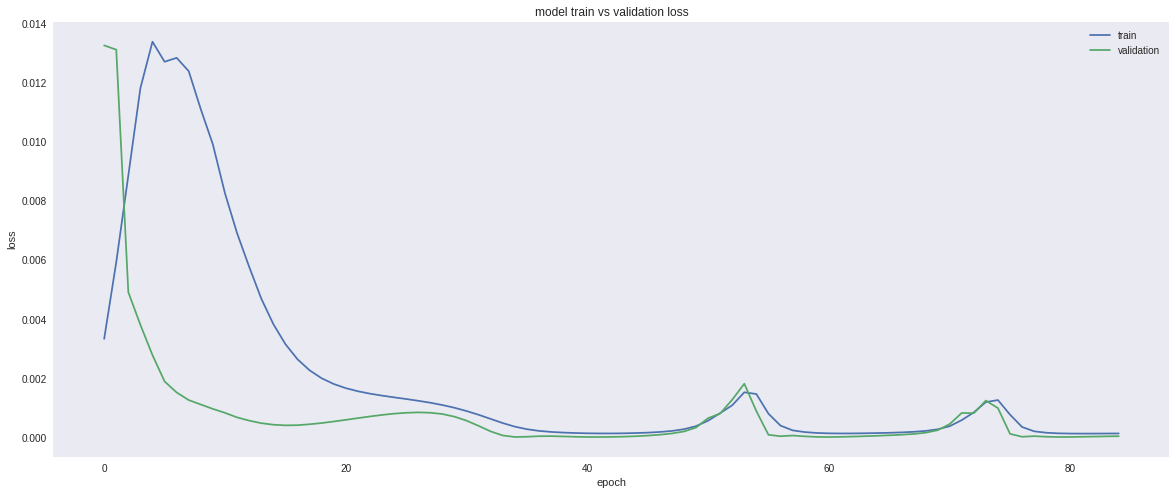

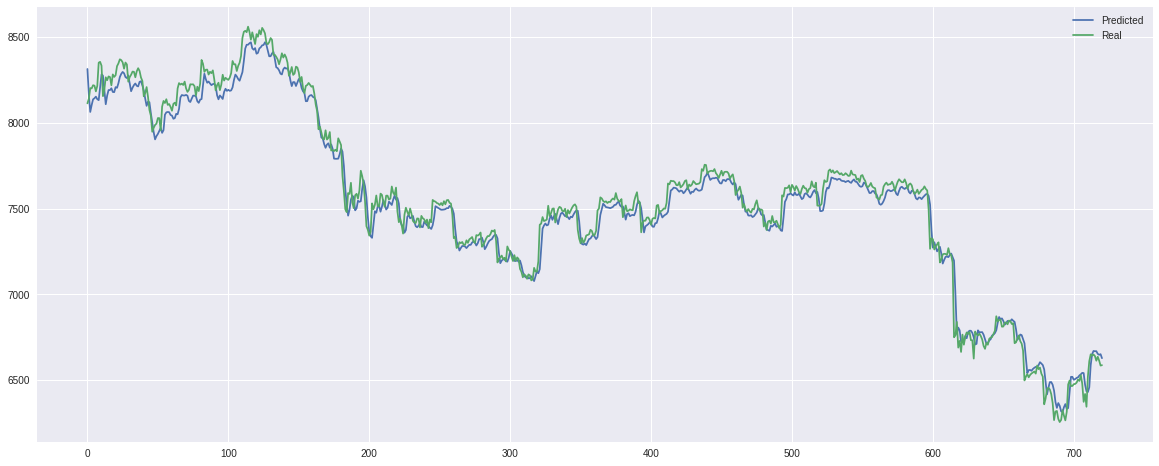

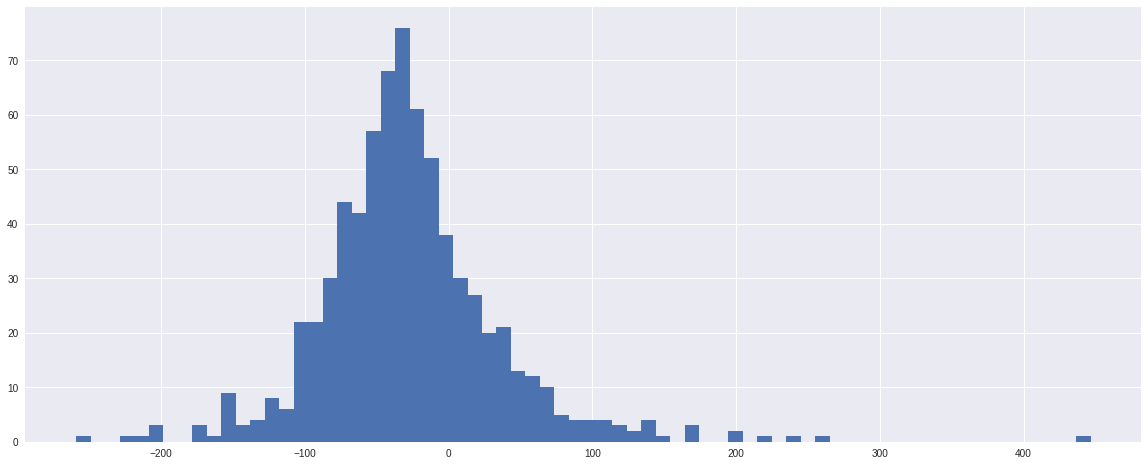

In [0]:
Close_predictor = Close_pred.predict(Close_Xtest)
Close_predicted = Close_pred.predict(Close_Xtest)
close_price_predicted = recover_price(data, Close_pred, Close_predicted, yvar)
close_price_Ytest = recover_price(data, Close_pred, Close_Ytest.reshape(-1,1), yvar)

error(Close_history)
plot_prices(close_price_predicted[:], close_price_Ytest[:])
plot_histogram(close_price_predicted, close_price_Ytest)

# OPEN PRICE PREDICTOR

In [0]:
xvar = ('Open')
yvar = ('Open')
intl = 2

neurons=168
epochs=120
batch_size=20

data_Set, Open_Xtrain, Open_Xtest, Open_Ytrain, Open_Ytest = split(data, xvar, 
                                                                   yvar, intl)
Open_pred, Open_history = price_predic(neurons,
                                       epochs,
                                       batch_size,
                                       Open_Xtrain, Open_Xtest,
                                       Open_Ytrain, Open_Ytest)

ValueError: ignored

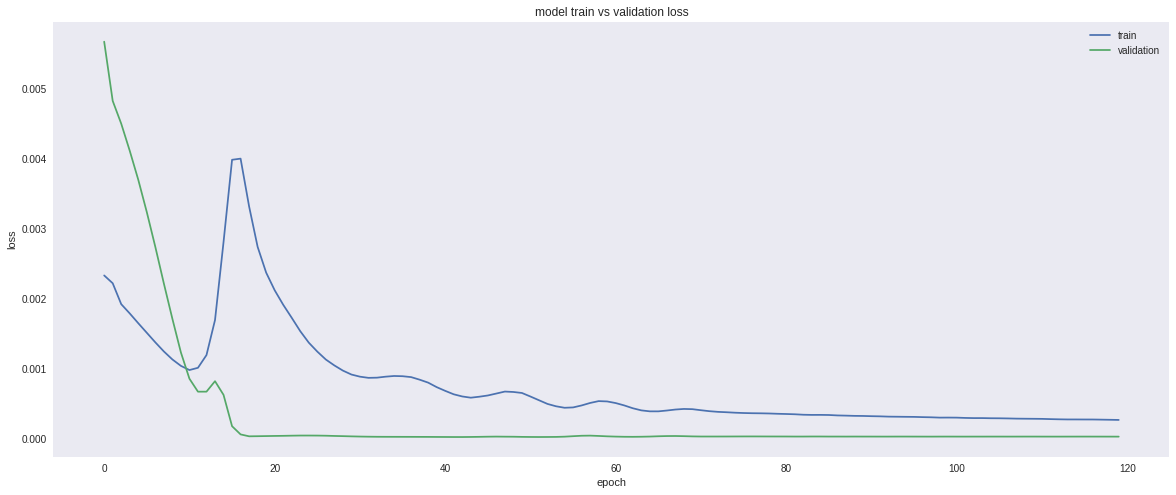

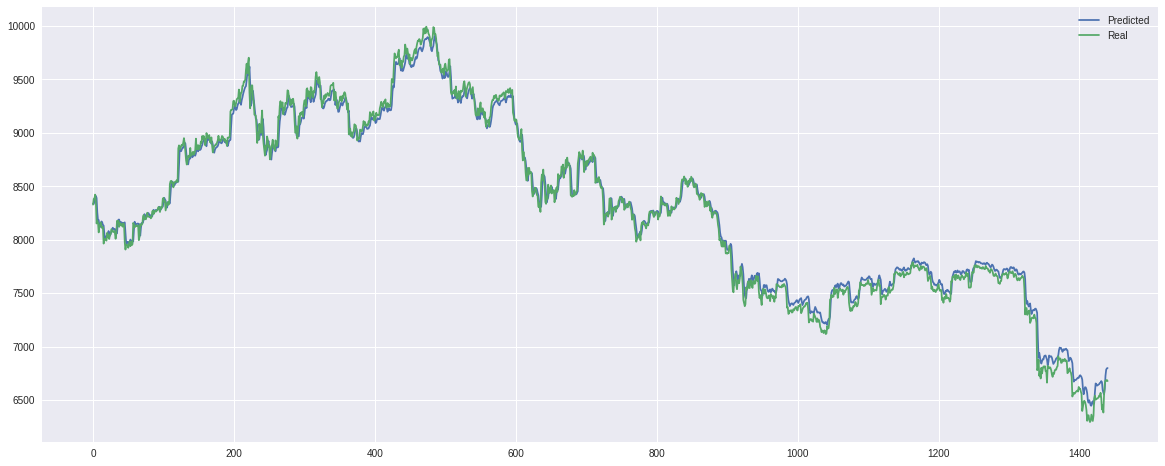

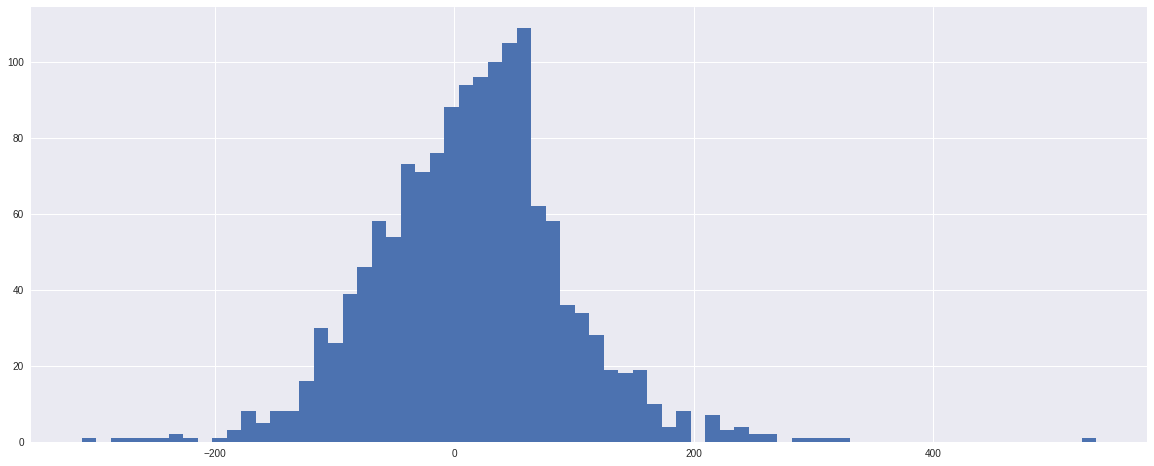

In [0]:
Open_predictor = Open_pred.predict(Open_Xtest)
Open_predicted = Open_pred.predict(Open_Xtest)
Open_price_predicted = recover_price(data, Open_pred, Open_predicted, yvar)
Open_price_Ytest = recover_price(data, Open_pred, Open_Ytest.reshape(-1,1), yvar)

error(Open_history)
plot_prices(Open_price_predicted, Open_price_Ytest)
plot_histogram(Open_price_predicted, Open_price_Ytest)

# HIGH PRICE PREDICTOR

In [0]:
xvar = ('Open', 'High', 'Low','Close')
yvar = ('High')
intl = 4

neurons=168
epochs=120
batch_size=20

data_Set, High_Xtrain, High_Xtest, High_Ytrain, High_Ytest = split(data, xvar, 
                                                                   yvar, intl)
High_pred, High_history = price_predic(neurons,
                                       epochs,
                                       batch_size,
                                       High_Xtrain, High_Xtest,
                                       High_Ytrain, High_Ytest)

Train on 5560 samples, validate on 1391 samples
Epoch 1/120
5560/5560 [==============================] - 18s 3ms/step - loss: 0.0015 - val_loss: 0.0053
Epoch 2/120
5560/5560 [==============================] - 9s 2ms/step - loss: 0.0015 - val_loss: 0.0046
Epoch 3/120
5560/5560 [==============================] - 9s 2ms/step - loss: 0.0017 - val_loss: 0.0023
Epoch 4/120
5560/5560 [==============================] - 10s 2ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 5/120
5560/5560 [==============================] - 9s 2ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 6/120
5560/5560 [==============================] - 9s 2ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 7/120
5560/5560 [==============================] - 9s 2ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 8/120
5560/5560 [==============================] - 9s 2ms/step - loss: 0.0035 - val_loss: 0.0020
Epoch 9/120
5560/5560 [==============================] - 9s 2ms/step - loss: 0.0045 - val_loss: 0.0018
Epoch 10/120
5560/5560 

5560/5560 [==============================] - 8s 2ms/step - loss: 2.5408e-04 - val_loss: 1.9138e-05
Epoch 76/120
5560/5560 [==============================] - 10s 2ms/step - loss: 2.5557e-04 - val_loss: 2.0815e-05
Epoch 77/120
5560/5560 [==============================] - 9s 2ms/step - loss: 2.5062e-04 - val_loss: 1.6893e-05
Epoch 78/120
5560/5560 [==============================] - 8s 2ms/step - loss: 2.4237e-04 - val_loss: 1.7166e-05
Epoch 79/120
5560/5560 [==============================] - 9s 2ms/step - loss: 2.3433e-04 - val_loss: 1.5798e-05
Epoch 80/120
5560/5560 [==============================] - 9s 2ms/step - loss: 2.1153e-04 - val_loss: 2.5752e-05
Epoch 81/120
5560/5560 [==============================] - 8s 2ms/step - loss: 1.8262e-04 - val_loss: 2.0877e-05
Epoch 82/120
5560/5560 [==============================] - 8s 2ms/step - loss: 1.9076e-04 - val_loss: 2.0722e-05
Epoch 83/120
5560/5560 [==============================] - 8s 2ms/step - loss: 1.9956e-04 - val_loss: 2.0496e-05
Epoc

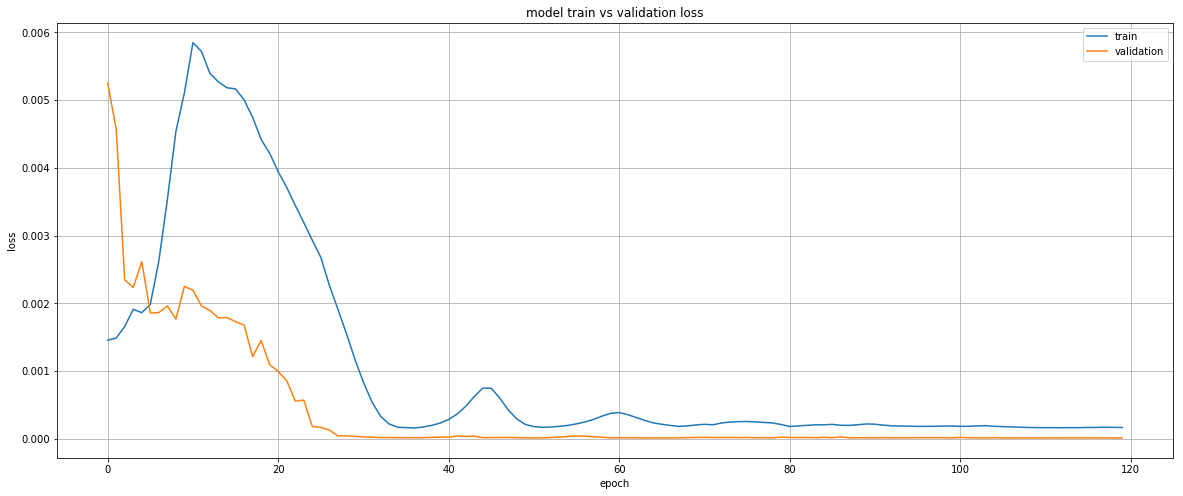

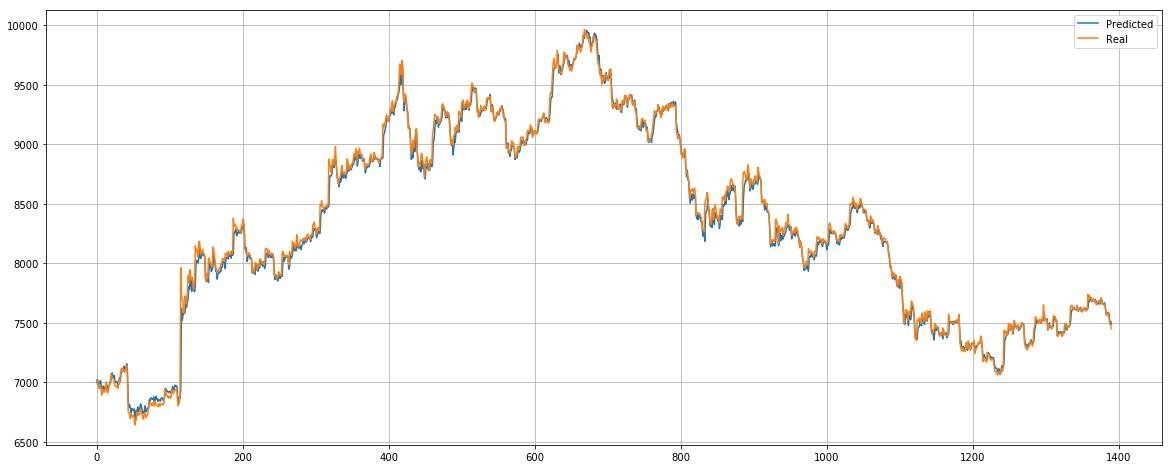

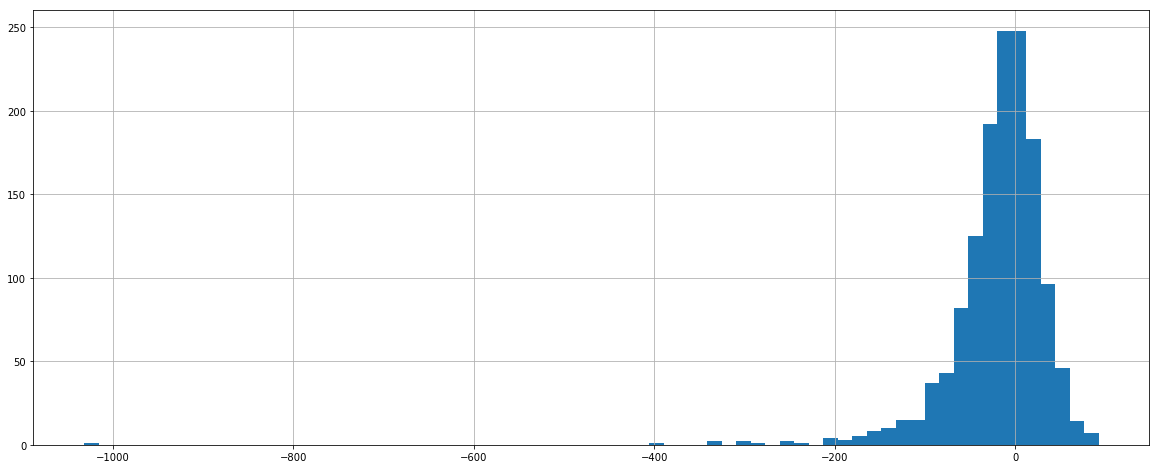

In [0]:
High_predictor = High_pred.predict(High_Xtest)
High_predicted = High_pred.predict(High_Xtest)
High_price_predicted = recover_price(data, High_pred, High_predicted, yvar)
High_price_Ytest = recover_price(data, High_pred, High_Ytest.reshape(-1,1), yvar)

error(High_history)
plot_prices(High_price_predicted, High_price_Ytest)
plot_histogram(High_price_predicted, High_price_Ytest)

# LOW PRICE PREDICTOR

In [0]:
xvar = ('Open', 'High', 'Low','Close')
yvar = ('Low')
intl = 4

neurons=168
epochs=120
batch_size=20

data_Set, Low_Xtrain, Low_Xtest, Low_Ytrain, Low_Ytest = split(data, xvar, 
                                                                   yvar, intl)
Low_pred, Low_history = price_predic(neurons,
                                       epochs,
                                       batch_size,
                                       Low_Xtrain, Low_Xtest,
                                       Low_Ytrain, Low_Ytest)

Train on 5560 samples, validate on 1391 samples
Epoch 1/120
5560/5560 [==============================] - 15s 3ms/step - loss: 0.0012 - val_loss: 0.0062
Epoch 2/120
5560/5560 [==============================] - 9s 2ms/step - loss: 0.0021 - val_loss: 0.0061
Epoch 3/120
5560/5560 [==============================] - 8s 2ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 4/120
5560/5560 [==============================] - 9s 2ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 5/120
5560/5560 [==============================] - 10s 2ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 6/120
5560/5560 [==============================] - 10s 2ms/step - loss: 0.0033 - val_loss: 0.0024
Epoch 7/120
5560/5560 [==============================] - 9s 2ms/step - loss: 0.0043 - val_loss: 0.0024
Epoch 8/120
5560/5560 [==============================] - 10s 2ms/step - loss: 0.0055 - val_loss: 0.0023
Epoch 9/120
5560/5560 [==============================] - 10s 2ms/step - loss: 0.0058 - val_loss: 0.0025
Epoch 10/120
5560/55

5560/5560 [==============================] - 9s 2ms/step - loss: 2.9986e-04 - val_loss: 9.9734e-06
Epoch 76/120
5560/5560 [==============================] - 9s 2ms/step - loss: 2.9428e-04 - val_loss: 9.6900e-06
Epoch 77/120
5560/5560 [==============================] - 9s 2ms/step - loss: 2.9246e-04 - val_loss: 9.3731e-06
Epoch 78/120
5560/5560 [==============================] - 10s 2ms/step - loss: 2.9453e-04 - val_loss: 9.8916e-06
Epoch 79/120
5560/5560 [==============================] - 10s 2ms/step - loss: 2.9153e-04 - val_loss: 1.1008e-05
Epoch 80/120
5560/5560 [==============================] - 10s 2ms/step - loss: 2.8885e-04 - val_loss: 1.0924e-05
Epoch 81/120
5560/5560 [==============================] - 10s 2ms/step - loss: 2.8522e-04 - val_loss: 1.0709e-05
Epoch 82/120
5560/5560 [==============================] - 9s 2ms/step - loss: 2.7854e-04 - val_loss: 1.0322e-05
Epoch 83/120
5560/5560 [==============================] - 9s 2ms/step - loss: 2.7676e-04 - val_loss: 1.0947e-05
E

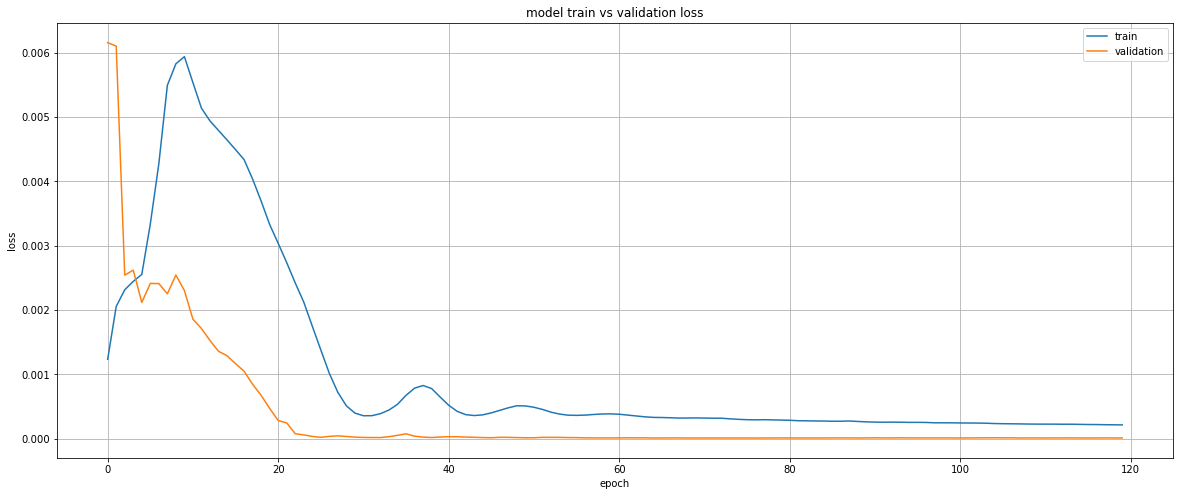

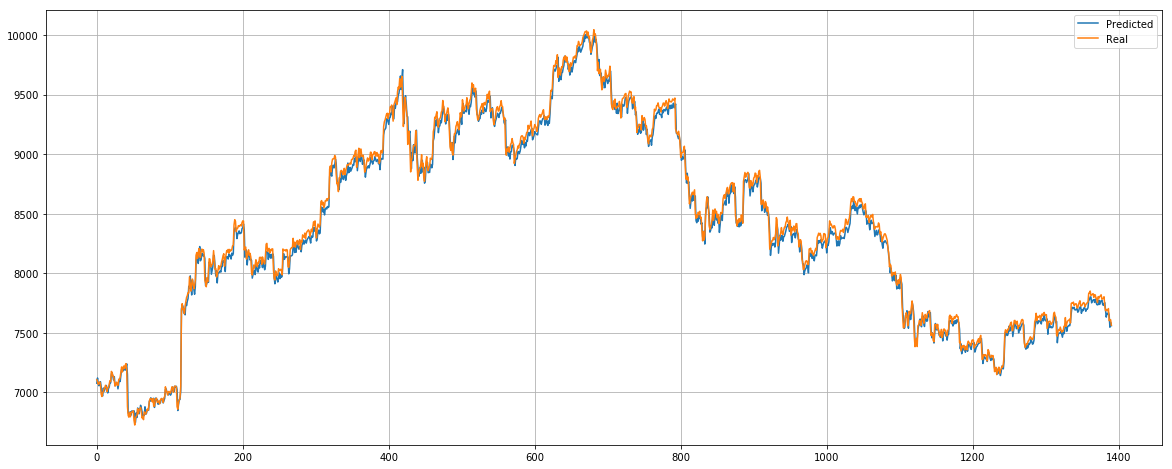

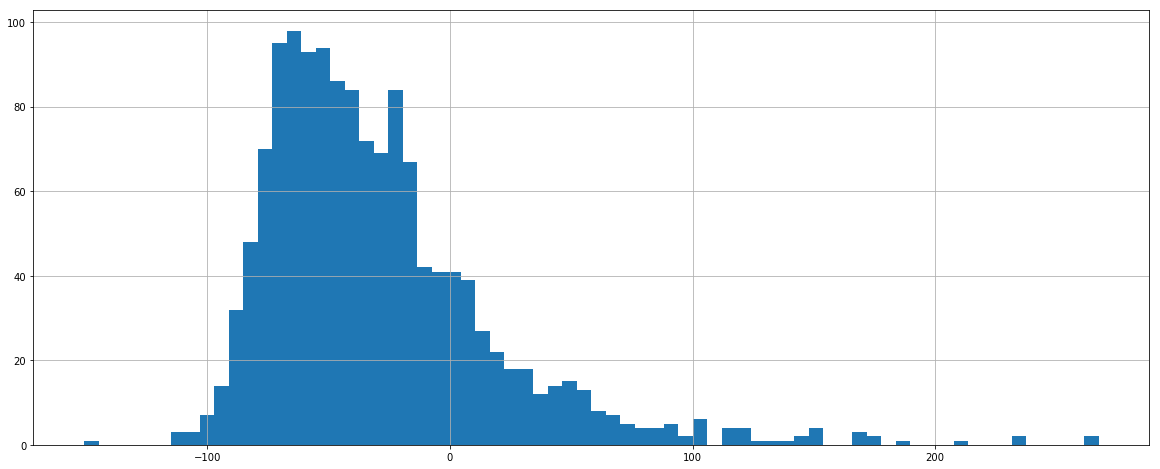

In [0]:
Low_predictor = Low_pred.predict(Low_Xtest)
Low_predicted = Low_pred.predict(Low_Xtest)
Low_price_predicted = recover_price(data, Low_pred, Low_predicted, yvar)
Low_price_Ytest = recover_price(data, Low_pred, Low_Ytest.reshape(-1,1), yvar)

error(Low_history)
plot_prices(Low_price_predicted, Low_price_Ytest)
plot_histogram(Low_price_predicted, Low_price_Ytest)

In [0]:
#SAVE MODEL
Open_pred.save('Open_pred.h5')
High_pred.save('High_pred.h5')
Low_pred.save('Low_pred.h5')
Close_pred.save('Close_pred.h5')

#HOW TO CALL THE SAVED MODEL:
#a = load_model('Open_pred.h5')
#Open_predictor = a.predict(Open_Xtest)
#plot_prices(Open_price_predicted, Open_price_Ytest)
#plot_histogram(Open_price_predicted, Open_price_Ytest)

In [0]:
def predictor(Open_Xtest, n=1):
    
    X = np.array(Open_Xtest[:1])
    predicted_prices = []
    
    Open_price = []
    High_price = []
    Low_price = []
    Close_price = []
    
    for i in range(n):
        Open = float(Open_pred.predict(X[:1]))
        High = float(High_pred.predict(X[:1]))
        Low = float(Close_pred.predict(X[:1]))
        Close = float(Low_pred.predict(X[:1]))
        
        predicted_prices.append(Open)
        predicted_prices.append(High)
        predicted_prices.append(Low)
        predicted_prices.append(Close)
        
        Open_price.append(Open)
        High_price.append(High)
        Low_price.append(Low)
        Close_price.append(Close)
        
        X[0][-1] = np.array(predicted_prices)
        predicted_prices = []
    
    return np.array(Open_price), np.array(High_price), np.array(Low_price), np.array(Close_price)

Open_price, High_price, Low_price, Close_price = predictor(Open_Xtest, 1)

Open_price = recover_price(data, Open_pred, Open_price.reshape(-1,1), ('Open'))
High_price = recover_price(data, High_pred, High_price.reshape(-1,1), ('High'))
Low_price = recover_price(data, Low_pred, Low_price.reshape(-1,1), ('Low'))
Close_price = recover_price(data, Close_pred, Close_price.reshape(-1,1), ('Close'))


#plt.figure(figsize=(20,8))
#plt.grid(True)
#plt.plot(Open_price, label='Open')
#plt.plot(High_price, label='High')
#plt.plot(Low_price, label='Low')
#plt.plot(Close_price, label='Close')
#plt.legend()
#plt.show()



print('Predicted open', Open_price[0])
print('Real open', Open_price_Ytest[:2][0])
print('-----------------------------------------------------------')
print('Predicted High', High_price[0])
print('Real High', High_price_Ytest[:2][0])
print('-----------------------------------------------------------')
print('Predicted Low', Low_price[0])
print('Real Low', Low_price_Ytest[:2][0])
print('-----------------------------------------------------------')
print('Predicted Close', Close_price[0])
print('Real Close', close_price_Ytest[:2][0])
print('-----------------------------------------------------------')

#print('Predicted open', Open_price[0], Open_price[1])
#print('Real open', Open_price_Ytest[:2][0], Open_price_Ytest[:2][1])
#print('-----------------------------------------------------------')
#print('Predicted High', High_price[0], High_price[1])
#print('Real High', High_price_Ytest[:2][0], High_price_Ytest[:2][1])
#print('-----------------------------------------------------------')
#print('Predicted Low', Low_price[0], Low_price[1])
#print('Real Low', Low_price_Ytest[:2][0], Low_price_Ytest[:2][1])
#print('-----------------------------------------------------------')
#print('Predicted Close', Close_price[0], Close_price[1])
#print('Real Close', close_price_Ytest[:2][0], close_price_Ytest[:2][1])
#ºprint('-----------------------------------------------------------')

Predicted open [ 7025.50390849]
Real open [ 7040.27372466]
-----------------------------------------------------------
Predicted High [ 6999.65495779]
Real High [ 7024.77327126]
-----------------------------------------------------------
Predicted Low [ 7006.02224534]
Real Low [ 7105.94971347]
-----------------------------------------------------------
Predicted Close [ 7076.93660006]
Real Close [ 7030.]
-----------------------------------------------------------


In [0]:
np.array(Open_Xtest[:1])

array([[[ 0.23702327,  0.23372751,  0.24111443,  0.23638307],
        [ 0.23809165,  0.23372751,  0.23561398,  0.23352491],
        [ 0.23571437,  0.23260042,  0.23969704,  0.2346565 ],
        [ 0.23684214,  0.24239228,  0.24111324,  0.24364968]]])